In [1]:
# %% [Instalación completa]
!apt-get update
!apt-get install -y poppler-utils tesseract-ocr tesseract-ocr-spa

!pip install --upgrade pip
!pip install pykeen pdf2image pytesseract Pillow nltk networkx matplotlib transformers torch huggingface-hub  pymupdf unidecode spacy owlready2
!pip install langdetect
# Descarga recursos NLTK
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')  # Útil para análisis adicional

!python -m spacy download es_core_news_lg

Get:1 https://cli.github.com/packages stable InRelease [3,917 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,580 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,863 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,634 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [6,411 kB]
Get:14 http://s

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.0/568.0 MB 18.8 MB/s  0:00:21
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
!pip install mistralai

INFO: pip is looking at multiple versions of opentelemetry-sdk to determine which version is compatible with other requirements. This could take a while.
  Attempting uninstall: opentelemetry-proto
    Found existing installation: opentelemetry-proto 1.37.0
    Uninstalling opentelemetry-proto-1.37.0:
      Successfully uninstalled opentelemetry-proto-1.37.0
  Attempting uninstall: opentelemetry-exporter-otlp-proto-common
    Found existing installation: opentelemetry-exporter-otlp-proto-common 1.37.0
    Uninstalling opentelemetry-exporter-otlp-proto-common-1.37.0:
      Successfully uninstalled opentelemetry-exporter-otlp-proto-common-1.37.0
  Attempting uninstall: opentelemetry-api
    Found existing installation: opentelemetry-api 1.37.0
    Uninstalling opentelemetry-api-1.37.0:
      Successfully uninstalled opentelemetry-api-1.37.0
  Attempting uninstall: opentelemetry-semantic-conventions
    Found existing installation: opentelemetry-semantic-conventions 0.58b0
    Uninstallin

In [3]:
STOPWORDS = set(
    [
        "introducción",
        "método",
        "métodos",
        "resultado",
        "resultados",
        "discusión",
        "conclusión",
        "figura",
        "tabla",
        "referencia",
        "estudio",
        "análisis",
        "datos",
        "artículo",
        "sección",
        "mostrado",
        "usando",
        "usado",
        "basado",
        "encontrado",
        "también",
        "sin embargo",
        "aunque",
        "año",
        "años",
        "tiempo",
        "alto",
        "bajo",
        "valor",
        "caso",
        "grupo",
        "et",
        "al",
        "probabilidad",
        "momento",
        "situaciones",
        "descubrir",
        "mantiene",
        "significaba",
        "quizás",
        "debido",
        "uso",
        "hacer",
        "obtener",
        "puede",
        "podría",
        "listado",
        "conferencias",
        "antecedentes",
        "significancia",
        "derechos de autor",
        "autor",
        "fig",
        "ec",
        "vol",
    ]
)

BLACKLIST = {
    "fig", "figura", "figure", "tabla", "table", "cuadro", "doi", "issn",
    "url", "http", "www", "et", "al", "vol", "no", "pág", "pag", "ed",
    "estudio", "análisis", "datos", "método", "resultado", "conclusión" # Palabras genéricas
}

In [4]:
from idna import decode
import pdf2image
import fitz
import pytesseract
from unidecode import unidecode
import nltk
import hashlib
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
from pathlib import Path
import string
import spacy
import os
import re

try:
    nlp = spacy.load("es_core_news_lg")
    print("✅ Modelo spaCy 'es_core_news_lg' cargado correctamente.")
except OSError:
    print("⚠️ Error cargando spaCy. Asegúrate de haber ejecutado la celda de instalación.")


nltk.download("punkt")
nltk.download("stopwords")


ruta_local = os.path.expanduser("./model")
# Configurar la ruta de la carpeta
carpeta_txts = "./txts"
carpeta_pdfs = "./corpus"  # Carpeta en la raíz del proyecto
carpeta_pdfs = Path(carpeta_pdfs)
article_txt = ""
all_articles_text = []

# Asegurarse de que la carpeta existe
if not carpeta_pdfs.exists():
    carpeta_pdfs.mkdir(parents=True, exist_ok=True)
    print(f"Carpeta '{carpeta_pdfs}' creada. Coloca tus PDFs allí.")
else:
    # Procesar todos los PDFs en la carpeta
    # Initialize article_txt to ensure it's set for each iteration or if no PDFs are processed
    article_txt = ""  # Esta variable se usará globalmente, pero la reiniciaremos por PDF

    for pdf_file in carpeta_pdfs.glob("*.pdf"):
        print(f"\nProcesando: {pdf_file.name}")

        article_txt = ""  # Variable local para cada PDF

        try:
            # Construir nombre del archivo txt
            pdf_file_name = pdf_file.with_suffix(".txt").name
            file_name = Path("./txts") / pdf_file_name

            print(file_name)

            # Si ya existe el .txt, cargarlo
            if file_name.exists():
                print(f"  El archivo {file_name.name} ya existe. Cargando texto existente...")
                with open(file_name, "r", encoding="utf-8") as f:
                    article_txt = f.read()
            else:
                # --- Extracción nueva del PDF ---
                doc = fitz.open(pdf_file)
                full_text_pages = []

                for page in doc:
                    blocks = page.get_text("blocks", sort=True)
                    page_text_parts = []
                    for block in blocks:
                        txt = block[4]
                        if not txt.strip() or len(txt) < 5:
                            continue
                        txt = re.sub(r'([a-záéíóúñ])([A-ZÁÉÍÓÚÑ])', r'\1 \2', txt)
                        page_text_parts.append(txt)

                    full_text_pages.append("\n".join(page_text_parts))

                article_txt = "\n".join(full_text_pages)
                article_txt = re.sub(r'\s+', ' ', article_txt).strip()

                # Guardar el texto extraído
                file_name.parent.mkdir(parents=True, exist_ok=True)
                with open(file_name, "w", encoding="utf-8") as f:
                    f.write(article_txt)

                print(f"  Texto extraído y guardado en {file_name.name}")

            # Agregar a la lista de todos los textos
            if article_txt.strip():
                print(article_txt)  # Solo si no está vacío
                all_articles_text.append(article_txt)

        except Exception as e:
            print(f"  Error procesando {pdf_file.name}: {e}")

# Combinar todos los textos
combined_text = "\n\n".join(all_articles_text)

✅ Modelo spaCy 'es_core_news_lg' cargado correctamente.

Procesando: Adenomas Secretores de Prolactina. 2006.pdf
txts/Adenomas Secretores de Prolactina. 2006.txt
  Texto extraído y guardado en Adenomas Secretores de Prolactina. 2006.txt
Neurocirugía 2006; 17: 226-231 Cirugia transeptoesfenoidal en adenomas hipofisarios productores de prolactina O. López-Arbolay; O. Morales-Sabina; J.L. González-González y N. Valdés-Lorenzo Servicio de Neurocirugía. Hospital Clínico Quirúrgico “Hermanos Ameijeiras". Ciudad de la Habana. Cuba. Resumen Transsphenoidal approach to prolactinomas Summary Introduction. Transeptal transsphenoidal surgery for pituitary tumors is a well established surgical tech- nique. In particular the use of medical treatment in patient with prolactinomas has induced the control of hiperprolactinemia and the shrinkage of the tumor in the great majority of the patients, for that reason the treatment of the prolactinomas is controversial. Objective. We evaluate the results of t

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


  Texto extraído y guardado en Rev española de Neurocirugía .txt
1HXURFLUXJt D    &LUXJt DWUDQVQDVDOWUDQVHVIHQRLGDOHQGRVFy SLFDHQDIHFFLRQHVGHUHJLy QVHODU -/*RQ]i OH]*RQ]i OH] 2/y SH]$UEROD\ 20RUDOHV6DELQD -)0DUWt3Lx HLUR\59LGDO9HUGLDO 6HUYLFLRGH1HXURFLUXJt D+RVSLWDO+HUPDQRV$PHLMHLUDV&LXGDGGHOD+DEDQD&XED 5HVXPHQ IDVH,,GHOHQVD\R DOHDWRUL]DGD\FRQWURODGD HQEXVFD GHLQIRUPDFLy QPi VFRQVLVWHQWHHQUHODFLy QDOYDORUUHDO GHODWp FQLFDDHVWDVDOWXUDVGHOGHVDUUROORGHODFLUXJt D KLSR¿VDULD 3$/$%5$6&/$9( $ERUGDMH$GHQRPHFWRPt D(QGRV Fy SLFD )t VWXODV 0DFURDGHQRPDV 7UDQVQDVDO 7UDQVHV IHQRLGDO 7UDQVQDVDOWUDQVVSKHQRLGDOHQGRVFRSLFVXUJHU\RIWKH VHOODUUHJLRQ 6XPPDU\  ,QWURGXFFLy Q 3DUD XQ JUDQ Q~PHUR GH WXPRUHV SLWXLWDULRVODFLUXJt DHVHOWUDWDPLHQWRGHSULPHUDOt QHD \ HO DERUGDMH WUDQVHVIHQRLGDO PLFURTXLU~UJLFR HO Pi V XWLOL]DGR(QHVWRVPRPHQWRVHOPLVPRVHHMHFXWDWDQWR SRUODY

In [5]:
from langdetect import detect, LangDetectException

def is_spanish(text):
    try:
        # Si el texto es muy corto, langdetect falla o es impreciso
        if len(text.split()) < 4:
            return False
        return detect(text) == 'es'
    except LangDetectException:
        return False

# Mejora en la limpieza de texto para unir palabras partidas por guiones
def clean_text(text):
    # 1. Eliminar referencias (igual que tenías)
    text = re.split(r'\n\s*(Referencia|Bibliograf|Bibliography|References)', text, flags=re.IGNORECASE)[0]

    # 2. Arreglar palabras partidas por guiones al final de línea (hyphenation)
    # Reemplaza "palabra- \n completada" por "palabracompletada"
    text = re.sub(r'(\w)-\n(\w)', r'\1\2', text)

    # 3. Eliminar encabezados repetitivos (headers) que rompen el flujo
    # Esto ayuda con "ra nasosinusal dioanatomicas" si es un header colado
    lines = text.split('\n')
    clean_lines = []
    for line in lines:
        # Filtra líneas que sean solo números o muy cortas (basura de paginación)
        if len(line.strip()) < 3 or line.strip().isdigit():
            continue
        clean_lines.append(line.strip())

    text = " ".join(clean_lines)

    # 4. Limpieza estándar
    text = re.sub(r'\s+', ' ', text).strip()
    return text

print(combined_text)
ctext = clean_text(combined_text)
sentences = nltk.tokenize.sent_tokenize(ctext, language="spanish")
print(sentences)
print(ctext)

Neurocirugía 2006; 17: 226-231 Cirugia transeptoesfenoidal en adenomas hipofisarios productores de prolactina O. López-Arbolay; O. Morales-Sabina; J.L. González-González y N. Valdés-Lorenzo Servicio de Neurocirugía. Hospital Clínico Quirúrgico “Hermanos Ameijeiras". Ciudad de la Habana. Cuba. Resumen Transsphenoidal approach to prolactinomas Summary Introduction. Transeptal transsphenoidal surgery for pituitary tumors is a well established surgical tech- nique. In particular the use of medical treatment in patient with prolactinomas has induced the control of hiperprolactinemia and the shrinkage of the tumor in the great majority of the patients, for that reason the treatment of the prolactinomas is controversial. Objective. We evaluate the results of trassphenoi- dal microsurgical treatment of prolactin secreting adenomas at our Unit. Methods. We made a retrospective analysis of 63 pa- tients operated on via transsphenoidal microsurgical technique for prolactin secreting adenomas betw

In [6]:
from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification

# Reemplazo de spaCy: Cargar pipeline de Hugging Face para NER biomédico en español
model_name = "HUMADEX/spanish_medical_ner"
try:
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    model = AutoModelForTokenClassification.from_pretrained(model_name)

    # 2. Pasar el tokenizador explícito al pipeline
    ner_pipeline = pipeline(
        "ner",
        model=model,
        tokenizer=tokenizer,
        aggregation_strategy="max" # O prueba "first" o "max" si simple falla
    )
except Exception as e:
    print(f"Error cargando modelo: {e}")
    raise

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/367 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

Device set to use cpu


In [7]:
entity_list = []

ENGLISH_STOPWORDS = {"the", "of", "and", "in", "to", "with", "a", "for", "study", "fistulae", "skull", "base", "flap", "nasoseptal"}
STOPWORDS.update(ENGLISH_STOPWORDS)

entity_list = []

# Tokenizar oraciones
sentences = nltk.tokenize.sent_tokenize(ctext, language="spanish")

for s in sentences:
    # 1. FILTRO DE IDIOMA: Si la oración no es español, sáltala completamente
    if not is_spanish(s):
        continue

    if len(s) < 20: continue

    # Ejecutar NER
    results = ner_pipeline(s)
    doc = nlp(s)

    denotations = []
    seen_lemmas = set() # Para evitar duplicados en la misma oración, pero sin romper orden interno

    for ent in results:
        if ent["score"] < 0.60: continue

        # Obtener span de spaCy para lematización precisa
        span = doc.char_span(ent["start"], ent["end"], alignment_mode="contract")

        if not span:
            # Fallback simple si spaCy no alinea: usar la palabra cruda
            lemma = ent["word"].strip().lower()
        else:
            # --- CORRECCIÓN CRÍTICA AQUÍ ---
            # NO usar set(). Usar lista para mantener orden: "mucosa nasal" != "nasal mucosa"
            lemma_parts = [t.lemma_.lower() for t in span]
            lemma = " ".join(lemma_parts)
            lemma = unidecode(lemma) # Quitar acentos para normalizar grafo

        # Limpieza final del lema
        lemma = re.sub(r'[^\w\s]', '', lemma).strip() # Quitar puntuación

        # Filtros de calidad del nodo
        if (len(lemma) < 4 or
            lemma in STOPWORDS or
            lemma in BLACKLIST or
            lemma.isdigit() or
            any(w in ENGLISH_STOPWORDS for w in lemma.split())): # Si contiene palabras en inglés
            continue

        label = ent["entity_group"]

        # Evitar agregar el mismo nodo dos veces para la misma oración
        if lemma not in seen_lemmas:
            denotations.append({
                "obj": label,
                "span": {"begin": ent["start"], "end": ent["end"]},
                "lemma": lemma, # Ahora es "cirugia endoscopica", no "endoscopica cirugia"
                "original": ent["word"]
            })
            seen_lemmas.add(lemma)

    if denotations:
        entity_list.append({"text": s, "denotations": denotations})

print(entity_list)

[{'text': 'Neurocirugía 2006; 17: 226-231 Cirugia transeptoesfenoidal en adenomas hipofisarios productores de prolactina O. López-Arbolay; O. Morales-Sabina; J.L.', 'denotations': [{'obj': 'TREATMENT', 'span': {'begin': 0, 'end': 12}, 'lemma': 'neurocirugia', 'original': 'Neurocirugía'}, {'obj': 'TREATMENT', 'span': {'begin': 31, 'end': 38}, 'lemma': 'cirugia', 'original': 'Cirugia'}, {'obj': 'TREATMENT', 'span': {'begin': 39, 'end': 58}, 'lemma': 'transeptoesfenoidal', 'original': 'transeptoesfenoidal'}, {'obj': 'PROBLEM', 'span': {'begin': 62, 'end': 70}, 'lemma': 'adenomas', 'original': 'adenomas'}, {'obj': 'PROBLEM', 'span': {'begin': 71, 'end': 95}, 'lemma': 'hipofisario productor', 'original': 'hipofisarios productores'}, {'obj': 'TREATMENT', 'span': {'begin': 99, 'end': 109}, 'lemma': 'prolactina', 'original': 'prolactina'}, {'obj': 'PROBLEM', 'span': {'begin': 113, 'end': 119}, 'lemma': 'lópez', 'original': 'López -'}, {'obj': 'PROBLEM', 'span': {'begin': 119, 'end': 126}, 'lem

In [8]:
parsed_entities = []
for entities_in_sentence in entity_list:
    e = []
    # If there are not entities in the text
    if not entities_in_sentence.get("denotations"):
        parsed_entities.append(
            {
                "text": entities_in_sentence["text"],
                "text_sha256": hashlib.sha256(
                    entities_in_sentence["text"].encode("utf-8")
                ).hexdigest(),
            }
        )
        continue
    for entity_denotation in entities_in_sentence["denotations"]:
        # The 'denotations' created above do not have an 'id' list.
        # The 'lemma' field is intended to be the unique identifier for the graph node.
        entity_id = entity_denotation["lemma"] # Use lemma as the ID
        other_ids = [] # No other IDs are being generated in this pipeline currently.
        entity_type = entity_denotation["obj"]

        # Use the already normalized lemma from the denotation for the entity name in the graph
        processed_lemma_for_graph = entity_denotation["lemma"]

        # Apply final filtering steps to this processed_lemma
        if processed_lemma_for_graph in STOPWORDS or len(processed_lemma_for_graph) < 3 or len(processed_lemma_for_graph) > 60 or processed_lemma_for_graph.isdigit() or not re.search(r'[a-záéíóúñ]', processed_lemma_for_graph, re.I):
            continue

        e.append(
            {
                "entity_id": entity_id, # This is the normalized lemma
                "other_ids": other_ids, # This will be empty
                "entity_type": entity_type,
                "entity": processed_lemma_for_graph, # Use the consistent lemma for the entity name in the graph
                "start": entity_denotation["span"]["begin"], # Add start index
                "end": entity_denotation["span"]["end"]    # Add end index
            }
        )

    parsed_entities.append(
        {
            "entities": e,
            "text": entities_in_sentence["text"],
            "text_sha256": hashlib.sha256(entities_in_sentence["text"].encode("utf-8")).hexdigest(),
        }
    )


🕸️ Construyendo grafo basado en sintaxis...
✅ Grafo construido: 441 nodos y 873 conexiones.
Grafo original: 441 nodos.
Grafo filtrado (Grado >= 1 y Betweenness >= 0.01): 49 nodos.
💾 Guardado archivo 'knowledge_graph_syntax.gexf'.


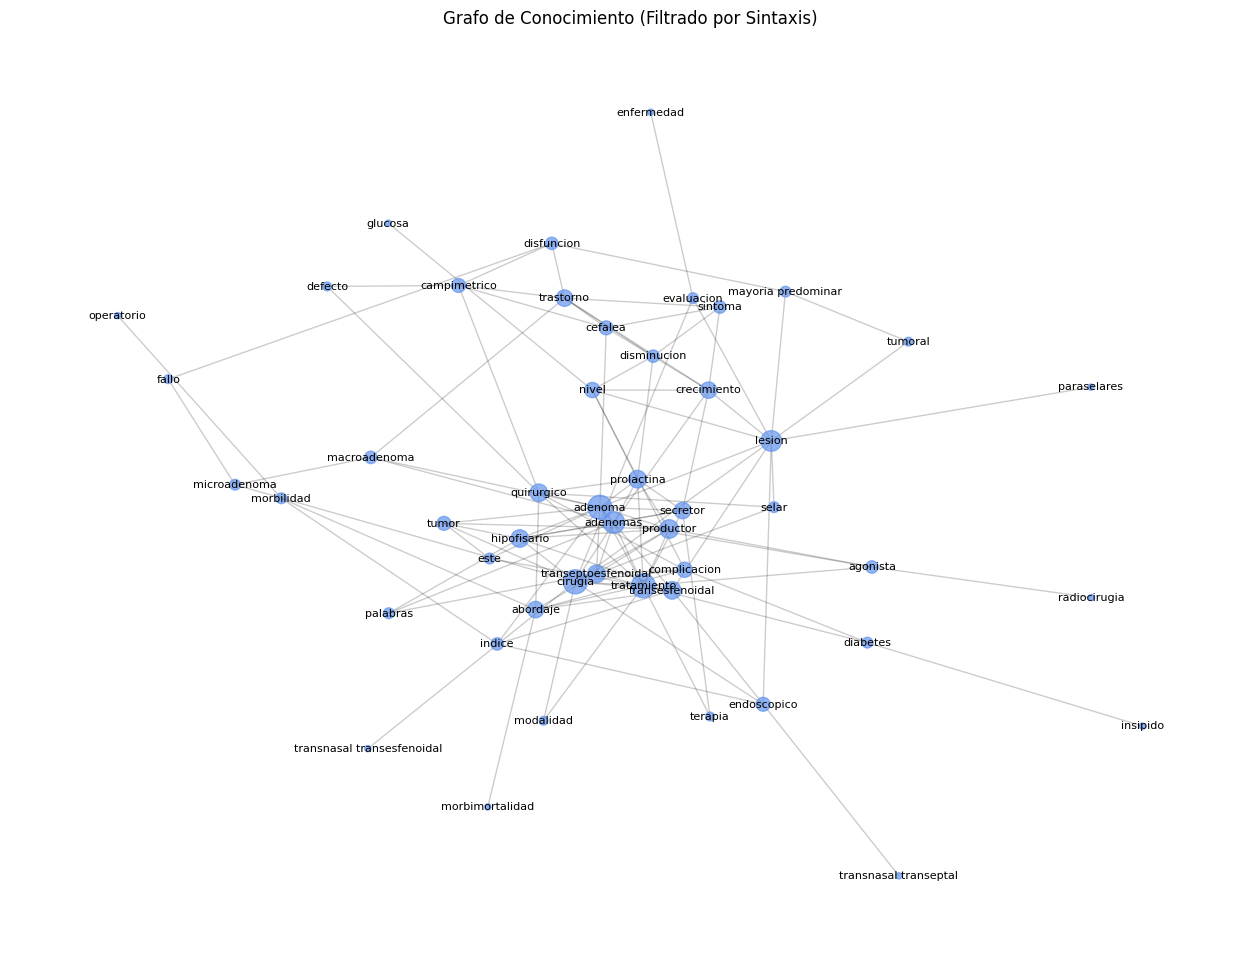

In [9]:
def check_dependency(token1, token2):
    """
    Retorna True si hay una conexión gramatical fuerte entre dos tokens.
    """
    # 1. Uno es ancestro del otro (ej: "tumor" -> "cerebral")
    if token1 in token2.ancestors or token2 in token1.ancestors:
        return True

    # 2. Comparten el mismo padre inmediato y ese padre es VERBO o AUXILIAR
    # Ej: "La resección (Sujeto) ELIMINÓ (Verbo) el tumor (Objeto)"
    if token1.head == token2.head and token1.head.pos_ in ["VERB", "AUX"]:
        return True

    return False

# Asumiendo que nlp, check_dependency y parsed_entities están definidos previamente

G = nx.Graph()

print("🕸️ Construyendo grafo basado en sintaxis...")

for item in parsed_entities:
    sentence_text = item["text"]
    entities = item["entities"]

    # Analizamos la oración con spaCy
    doc = nlp(sentence_text)

    spacy_entities = []

    # 1. Alinear entidades del NER (caracteres) con Tokens de spaCy
    for ent in entities:
        # char_span crea un Span de spaCy basado en indices de caracteres
        # alignment_mode="contract" asegura que no rompamos palabras a la mitad
        span = doc.char_span(ent["start"], ent["end"], alignment_mode="contract")

        if span:
            spacy_entities.append({
                "span": span,     # El objeto Span de spaCy
                "lemma": ent["entity_id"], # El nombre para el nodo del grafo
                "type": ent["entity_type"]
            })

    # 2. Evaluar pares posibles
    if len(spacy_entities) < 2:
        continue

    pairs = combinations(spacy_entities, 2)

    for e1, e2 in pairs:
        # Obtenemos la raíz sintáctica de la entidad (ej: en "cancer de pulmón", la raíz es "cancer")
        root1 = e1["span"].root
        root2 = e2["span"].root

        # VERIFICACIÓN SINTÁCTICA o co-ocurrencia
        add_edge = False
        weight_increment = 1

        if check_dependency(root1, root2):
            add_edge = True
            weight_increment = 2  # Mayor peso para dependencias sintácticas
        elif abs(root1.i - root2.i) < 5:  # Co-ocurrencia si raíces están cerca (menos de 5 tokens de distancia)
            add_edge = True

        if add_edge:
            source = e1["lemma"]
            target = e2["lemma"]

            # Añadir al grafo
            if G.has_edge(source, target):
                G[source][target]["weight"] += weight_increment
            else:
                G.add_edge(source, target, weight=weight_increment)

print(f"✅ Grafo construido: {G.number_of_nodes()} nodos y {G.number_of_edges()} conexiones.")


print(f"Grafo original: {G.number_of_nodes()} nodos.")

# 1. Eliminar nodos aislados o con muy pocas conexiones (Ruido)
min_degree = 1
nodes_to_remove_degree = [node for node, degree in dict(G.degree()).items() if degree < min_degree]

# Filtrado adicional por betweenness centrality para eliminar ruido
betweenness = nx.betweenness_centrality(G)
nodes_to_remove_betweenness = [node for node in G if betweenness[node] < 0.01]

nodes_to_remove = set(nodes_to_remove_degree).union(nodes_to_remove_betweenness)
G.remove_nodes_from(nodes_to_remove)

print(f"Grafo filtrado (Grado >= {min_degree} y Betweenness >= 0.01): {G.number_of_nodes()} nodos.")

# 2. Guardar GEXF para Gephi
nx.write_gexf(G, "knowledge_graph_syntax.gexf")
print("💾 Guardado archivo 'knowledge_graph_syntax.gexf'.")

# 3. Guardar lista de nodos
with open("nodos.txt", "w", encoding="utf-8") as f:
    for node in G.nodes():
        f.write(str(node) + "\n")

# 4. Visualización Rápida
if G.number_of_nodes() > 0:
    plt.figure(figsize=(16, 12))
    # Layout spring suele funcionar bien para visualizar clusters
    pos = nx.spring_layout(G, k=0.15, iterations=20)

    # Tamaño de nodos basado en grado
    d = dict(G.degree)
    node_sizes = [v * 20 for v in d.values()]

    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="#6495ED", alpha=0.7)
    nx.draw_networkx_edges(G, pos, alpha=0.2)
    # Solo ponemos etiquetas a los nodos más importantes para no saturar
    labels = {n: n for n in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_color="black")

    plt.title("Grafo de Conocimiento (Filtrado por Sintaxis)")
    plt.axis("off")
    plt.savefig("grafo_sintactico.png", dpi=300, bbox_inches="tight")
    plt.show()
else:
    print("⚠️ El grafo quedó vacío después del filtrado. Intenta bajar la exigencia del score NER o el grado mínimo.")

In [10]:
with open("nodos.txt", "w", encoding="utf-8") as f:
    for node in G.nodes():
        f.write(str(node) + "\n")

## Validacion del grafo

In [11]:
import os
import requests
import networkx as nx
from difflib import get_close_matches
from owlready2 import get_ontology, World

# ==========================================
# CLASE 1: OntologyLoader (Adaptada de tu ontologies_loader.py)
# ==========================================
import os
import requests
import networkx as nx
from difflib import get_close_matches
from owlready2 import get_ontology, World

# ==========================================
# CLASE 1: OntologyLoader
# ==========================================
class OntologyLoader:
    def __init__(self, cache_dir="./cache_ontologies"):
        self.cache_dir = cache_dir
        if not os.path.exists(self.cache_dir):
            os.makedirs(self.cache_dir)
        self.world = World()

    def load_from_url(self, url, filename=None):
        """Descarga y carga una ontología desde una URL, usando caché local."""
        if not filename:
            filename = url.split('/')[-1]
            if not filename.endswith('.owl') and not filename.endswith('.ttl'):
                filename += '.owl'

        local_path = os.path.join(self.cache_dir, filename)

        if not os.path.exists(local_path):
            print(f"⬇️ Descargando ontología desde {url}...")
            try:
                response = requests.get(url, timeout=60, stream=True)
                response.raise_for_status()
                with open(local_path, 'wb') as f:
                    for chunk in response.iter_content(chunk_size=8192):
                        f.write(chunk)
                print(f"✅ Guardado en {local_path}")
            except Exception as e:
                print(f"❌ Error descargando ontología: {e}")
                return None
        else:
            print(f"📂 Cargando ontología desde caché: {local_path}")

        try:
            onto = self.world.get_ontology(local_path).load()
            return onto
        except Exception as e:
            print(f"⚠️ Error cargando ontología con owlready2: {e}")
            return None

    def get_term_labels(self, ontology):
        """Extrae todas las etiquetas (labels) para matching difuso."""
        labels = set()
        if not ontology:
            return labels

        for c in ontology.classes():
            labels.add(c.name.lower())
            if hasattr(c, 'label'):
                for l in c.label:
                    labels.add(str(l).lower())
        return labels

    def get_relationships(self, ontology):
        """Extrae relaciones válidas (object properties) de la ontología."""
        relationships = set()
        if not ontology:
            return relationships

        for prop in ontology.object_properties():
            relationships.add(prop.name.lower())
            if hasattr(prop, 'label'):
                for l in prop.label:
                    relationships.add(str(l).lower())
        return relationships

In [12]:
class GraphValidator:
    def __init__(self, ontology_urls=None):
        self.loader = OntologyLoader()
        self.known_terms = set()
        self.known_relationships = set()
        self.ontologies = []
        self.ontology_labels = {}  # NUEVO: para mapear términos a ontologías

        if ontology_urls:
            for url in ontology_urls:
                onto = self.loader.load_from_url(url)
                if onto:
                    self.ontologies.append(onto)
                    print("⚙️ Indexando términos y relaciones...", end="\r")
                    onto_labels = self.loader.get_term_labels(onto)
                    self.known_terms.update(onto_labels)
                    self.known_relationships.update(self.loader.get_relationships(onto))

                    # NUEVO: Guardar qué términos pertenecen a esta ontología
                    onto_name = url.split('/')[-1].split('.')[0]
                    for term in onto_labels:
                        if term not in self.ontology_labels:
                            self.ontology_labels[term] = set()
                        self.ontology_labels[term].add(onto_name)

                    print(f"✅ {len(self.known_terms)} términos, {len(self.known_relationships)} relaciones indexadas.")

    def validate_term(self, term):
        """Valida si un término existe (match exacto o difuso)."""
        term_lower = term.lower()

        if term_lower in self.known_terms:
            return {"status": "valid", "match": term_lower, "type": "exact"}

        matches = get_close_matches(term_lower, list(self.known_terms), n=1, cutoff=0.85)
        if matches:
            return {"status": "valid", "match": matches[0], "type": "fuzzy"}

        return {"status": "invalid", "match": None, "type": "none"}

    def validate_term_with_ontology(self, term):
        """Valida término y devuelve en qué ontologías aparece."""
        term_lower = term.lower()
        matching_ontologies = set()

        if term_lower in self.known_terms:
            # NUEVO: Obtener las ontologías donde aparece este término
            matching_ontologies = self.ontology_labels.get(term_lower, set())
            return {
                "status": "valid",
                "match": term_lower,
                "type": "exact",
                "ontologies": list(matching_ontologies)  # NUEVO
            }

        # Para matches difusos, también necesitamos encontrar las ontologías
        matches = get_close_matches(term_lower, list(self.known_terms), n=1, cutoff=0.85)
        if matches:
            matched_term = matches[0]
            matching_ontologies = self.ontology_labels.get(matched_term, set())
            return {
                "status": "valid",
                "match": matched_term,
                "type": "fuzzy",
                "ontologies": list(matching_ontologies)  # NUEVO
            }

        return {
            "status": "invalid",
            "match": None,
            "type": "none",
            "ontologies": []  # NUEVO
        }

    def validate_edge(self, source, target, edge_type):
        """Valida una arista: nodos + tipo de relación."""
        source_validation = self.validate_term(str(source))
        target_validation = self.validate_term(str(target))

        edge_type_lower = str(edge_type).lower()
        edge_valid = edge_type_lower in self.known_relationships

        if not edge_valid:
            matches = get_close_matches(edge_type_lower, list(self.known_relationships), n=1, cutoff=0.85)
            if matches:
                edge_valid = True
                edge_match = matches[0]
            else:
                edge_match = None
        else:
            edge_match = edge_type_lower

        return {
            "source": source_validation,
            "target": target_validation,
            "edge_type": {
                "status": "valid" if edge_valid else "invalid",
                "match": edge_match,
                "original": edge_type
            },
            "fully_valid": (source_validation["status"] == "valid" and
                           target_validation["status"] == "valid" and
                           edge_valid)
        }


    def validate_graph(self, graph):
        """Valida nodos Y aristas del grafo NetworkX."""
        report = {
            "total_nodes": graph.number_of_nodes(),
            "valid_nodes": 0,
            "invalid_nodes": 0,
            "node_details": {},
            "total_edges": graph.number_of_edges(),
            "valid_edges": 0,
            "invalid_edges": 0,
            "edge_details": {},
            "ontology_coverage": {  # NUEVO: métricas de cobertura
                "total_unique_terms_matched": 0,
                "terms_by_ontology_count": {},
                "term_ontology_distribution": {}
            }
        }

        # NUEVO: Para calcular cobertura entre ontologías
        all_matched_terms = set()
        ontology_term_counts = {}
        term_ontology_map = {}  # Mapa término -> [ontologías]

        print(f"\n🔍 Validando {graph.number_of_nodes()} nodos...")
        for node in graph.nodes():
            result = self.validate_term_with_ontology(str(node))
            report["node_details"][node] = result

            # NUEVO: Acumular estadísticas de cobertura
            if result["status"] == "valid":
                report["valid_nodes"] += 1
                all_matched_terms.add(result["match"])

                # Contar por ontología
                for ontology in result["ontologies"]:
                    ontology_term_counts[ontology] = ontology_term_counts.get(ontology, 0) + 1

                # Mapear término a ontologías
                if result["match"] not in term_ontology_map:
                    term_ontology_map[result["match"]] = set()
                term_ontology_map[result["match"]].update(result["ontologies"])
            else:
                report["invalid_nodes"] += 1

        # NUEVO: Calcular métricas de cobertura
        report["ontology_coverage"]["total_unique_terms_matched"] = len(all_matched_terms)
        report["ontology_coverage"]["terms_by_ontology_count"] = ontology_term_counts
        report["ontology_coverage"]["term_ontology_distribution"] = {
            term: list(ontologies)
            for term, ontologies in term_ontology_map.items()
        }

        # Resto del código original para aristas...
        print(f"🔗 Validando {graph.number_of_edges()} aristas...")
        for i, (source, target, data) in enumerate(graph.edges(data=True)):
            edge_type = data.get('type', 'unknown')
            result = self.validate_edge(source, target, edge_type)
            edge_key = (source, target, edge_type)
            report["edge_details"][edge_key] = result

            if result["fully_valid"]:
                report["valid_edges"] += 1
            else:
                report["invalid_edges"] += 1

            if (i + 1) % 100 == 0:
                print(f"   Procesadas {i + 1}/{report['total_edges']} aristas...", end="\r")

        print()  # Nueva línea

        if report["total_nodes"] > 0:
            report["node_precision"] = report["valid_nodes"] / report["total_nodes"]
        else:
            report["node_precision"] = 0.0

        if report["total_edges"] > 0:
            report["edge_precision"] = report["valid_edges"] / report["total_edges"]
        else:
            report["edge_precision"] = 0.0

        return report

# ==========================================
# EJECUCIÓN DEL BENCHMARK
# ==========================================

# ==========================================
# EJECUCIÓN DEL BENCHMARK
# ==========================================

ontologies_map = {
    "HPO (Phenotypes)": "http://purl.obolibrary.org/obo/hp.owl",
    "DoCS": "http://purl.obolibrary.org/obo/doid/translations/doid-es.owl",
    "NCIT (Cancer/Bio)": "http://purl.obolibrary.org/obo/ncit.owl",
    "HPO (Español)": "http://purl.obolibrary.org/obo/hp/hp-international.owl",
    "DOID (Enfermedades - Español)": "http://purl.obolibrary.org/obo/doid/translations/doid-es.owl"
}


if 'G' not in locals():
    print("⚠️ ¡Alerta! La variable 'G' no está definida.")
else:
    print(f"🚀 Iniciando evaluación del grafo ({G.number_of_nodes()} nodos, {G.number_of_edges()} aristas)...\n")
    print(f"{'Ontología':<25} | {'Nodos V/I':<12} | {'Aristas V/I':<13} | {'Prec. Nodos':<12} | {'Prec. Aristas':<14}")
    print("-" * 95)

    results_summary = []

    # NUEVO: Variables para estadísticas globales
    all_terms_in_graph = set(G.nodes())
    all_matched_terms_global = set()
    term_ontology_count_global = {}  # término -> número de ontologías donde aparece
    ontology_overlap_stats = {}  # Para cada ontología, cuántos términos únicos

    for name, url in ontologies_map.items():
        try:
            validator = GraphValidator(ontology_urls=[url])
            report = validator.validate_graph(G)

            nodes_str = f"{report['valid_nodes']}/{report['invalid_nodes']}"
            edges_str = f"{report['valid_edges']}/{report['invalid_edges']}"
            node_prec = report['node_precision']
            edge_prec = report['edge_precision']

            print(f"{name:<25} | {nodes_str:<12} | {edges_str:<13} | {node_prec:>10.2%} | {edge_prec:>12.2%}")

            # NUEVO: Acumular datos globales
            ontology_overlap_stats[name] = {
                'unique_terms_matched': report['ontology_coverage']['total_unique_terms_matched'],
                'details': report['ontology_coverage']
            }

            # Acumular términos coincidentes
            for term, ontologies in report['ontology_coverage']['term_ontology_distribution'].items():
                all_matched_terms_global.add(term)
                term_ontology_count_global[term] = term_ontology_count_global.get(term, 0) + len(ontologies)

            results_summary.append({
                "ontology": name,
                "node_precision": node_prec,
                "edge_precision": edge_prec,
                "details": report
            })

        except Exception as e:
            print(f"{name:<25} | ❌ ERROR: {str(e)}")

    print("-" * 95)
    print("\n✅ Benchmark Completado.")

    # NUEVO: Estadísticas de cobertura global
    print("\n📊 ESTADÍSTICAS DE COBERTURA GLOBAL")
    print("=" * 60)

    # 1. Términos únicos que coincidieron en total
    print(f"\n🔹 Términos únicos que coincidieron en AL MENOS una ontología: {len(all_matched_terms_global)}")

    # 2. Términos que NO aparecieron en NINGUNA ontología
    terms_not_found = all_terms_in_graph - all_matched_terms_global
    print(f"🔹 Términos NO encontrados en NINGUNA ontología: {len(terms_not_found)}")

    if terms_not_found:
        print("   Ejemplos (primeros 10):")
        for i, term in enumerate(list(terms_not_found)[:10]):
            print(f"   {i+1}. {term}")

    # 3. Top 10 términos con más apariciones en ontologías
    print(f"\n🏆 TOP 10 términos con más apariciones en ontologías:")
    sorted_terms = sorted(term_ontology_count_global.items(), key=lambda x: x[1], reverse=True)[:10]
    for i, (term, count) in enumerate(sorted_terms, 1):
        # Obtener en qué ontologías específicamente aparece
        ontologies_for_term = []
        for result in results_summary:
            if term in result['details']['ontology_coverage']['term_ontology_distribution']:
                ontologies_for_term.append(result['ontology'])

        print(f"   {i}. {term} ({count} ontologías)")
        print(f"      Aparece en: {', '.join(ontologies_for_term[:3])}" +
              ("..." if len(ontologies_for_term) > 3 else ""))

    # 4. Distribución por ontología
    print(f"\n📈 DISTRIBUCIÓN DE TÉRMINOS POR ONTOLOGÍA:")
    for ontology_name, stats in ontology_overlap_stats.items():
        print(f"   {ontology_name}: {stats['unique_terms_matched']} términos únicos")

    # 5. Solapamiento entre ontologías (opcional)
    if len(ontology_overlap_stats) > 1:
        print(f"\n🔄 SOLAPAMIENTO ENTRE ONTOLOGÍAS:")
        ontologies_list = list(ontology_overlap_stats.keys())
        for i in range(len(ontologies_list)):
            for j in range(i+1, len(ontologies_list)):
                onto1 = ontologies_list[i]
                onto2 = ontologies_list[j]

                # Términos de cada ontología (simplificado)
                terms1 = set(results_summary[i]['details']['ontology_coverage']['term_ontology_distribution'].keys())
                terms2 = set(results_summary[j]['details']['ontology_coverage']['term_ontology_distribution'].keys())

                common_terms = terms1.intersection(terms2)
                if common_terms:
                    print(f"   {onto1} ↔ {onto2}: {len(common_terms)} términos en común")

    if results_summary:
        best_result = max(results_summary, key=lambda x: (x['node_precision'] + x['edge_precision']) / 2)
        print(f"\n🔎 Mejor ontología: {best_result['ontology']}")
        print(f"   Precisión nodos: {best_result['node_precision']:.2%}")
        print(f"   Precisión aristas: {best_result['edge_precision']:.2%}")

        invalid_edges = [(k, v) for k, v in best_result['details']['edge_details'].items() if not v['fully_valid']]
        if invalid_edges:
            print(f"\n⚠️ Ejemplos de aristas inválidas (primeras 5):")
            for (s, t, et), details in invalid_edges[:5]:
                print(f"   {s} --[{et}]--> {t}")
                if details['edge_type']['status'] == 'invalid':
                    print(f"      └─ Tipo de arista '{et}' no encontrado en ontología")

🚀 Iniciando evaluación del grafo (49 nodos, 122 aristas)...

Ontología                 | Nodos V/I    | Aristas V/I   | Prec. Nodos  | Prec. Aristas 
-----------------------------------------------------------------------------------------------
⬇️ Descargando ontología desde http://purl.obolibrary.org/obo/hp.owl...
✅ Guardado en ./cache_ontologies/hp.owl
✅ 64043 términos, 424 relaciones indexadas.

🔍 Validando 49 nodos...
🔗 Validando 122 aristas...

HPO (Phenotypes)          | 6/43         | 0/122         |     12.24% |        0.00%
⬇️ Descargando ontología desde http://purl.obolibrary.org/obo/doid/translations/doid-es.owl...
✅ Guardado en ./cache_ontologies/doid-es.owl
✅ 38595 términos, 92 relaciones indexadas.

🔍 Validando 49 nodos...
🔗 Validando 122 aristas...

DoCS                      | 5/44         | 0/122         |     10.20% |        0.00%
⬇️ Descargando ontología desde http://purl.obolibrary.org/obo/ncit.owl...
✅ Guardado en ./cache_ontologies/ncit.owl
✅ 406513 términos, 194 

# Aristas faltantes

In [24]:
import networkx as nx
from itertools import combinations
from mistralai import Mistral
import json
import time

class Graph:
    def __init__(self):
        self.graph= nx.Graph()
        self.cache_file = "cache_etiquetas.json"
        self.cache = self._cargar_cache()

    def add_edge(self, source, target, relation='cooccurs_with'):
        if self.graph.has_edge(source, target):
            self.graph[source][target]["weight"] += 1
        else:
            self.graph.add_edge(source, target, weight=1, relation=relation)

    def build_relations(self, entity_names):
        pairs = combinations(entity_names, 2)

        for source, target in pairs:
            self.add_edge(source, target, relation='cooccurs_with')

    def build_graph(self, parsed_entities):
        for item in parsed_entities:
            if "entities" in item:
                entity_names = [e["entity"].lower().strip() for e in item["entities"]]
                entity_names = list(set(entity_names))

                # Si hay menos de 2 entidades, no podemos hacer una conexión
                if len(entity_names) < 2:
                    continue

                self.build_relations(entity_names)


    def _cargar_cache(self):
        """Carga el archivo JSON de caché si existe."""
        if os.path.exists(self.cache_file):
            try:
                with open(self.cache_file, 'r', encoding='utf-8') as f:
                    return json.load(f)
            except Exception as e:
                print(f"Aviso: No se pudo leer el caché ({e}). Se iniciará uno nuevo.")
                return {}
        return {}

    def _guardar_cache(self):
        """Guarda el estado actual del caché en el archivo JSON."""
        with open(self.cache_file, 'w', encoding='utf-8') as f:
            json.dump(self.cache, f, indent=4, ensure_ascii=False)

    def _obtener_key(self, u, v):
        """Genera una clave única para identificar la arista."""
        return f"{u}-->{v}"

    def analyze_topology(self):
        print("\n🕸️ Análisis Topológico:")
        n = self.graph.number_of_nodes()
        e = self.graph.number_of_edges()

        # 1. Densidad
        density = nx.density(self.graph)
        print(f"   • Densidad: {density:.4f}")

        # 2. Componentes Conectados (importante para saber si hay islas)
        if nx.is_directed(self.graph):
            n_components = nx.number_weakly_connected_components(self.graph)
        else:
            n_components = nx.number_connected_components(self.graph)
        print(f"   • Componentes Conectados: {n_components}")

        # 3. Grado Promedio
        avg_degree = sum(dict(self.graph.degree()).values()) / n
        print(f"   • Grado Promedio: {avg_degree:.2f}")

        # 4. Clustering (solo para no dirigidos o convertir primero)
        # Indica si los vecinos de un nodo también son vecinos entre sí (común en biología)
        try:
            avg_clustering = nx.average_clustering(self.graph.to_undirected())
            print(f"   • Coeficiente de Clustering: {avg_clustering:.4f}")
        except:
            pass

        return {"density": density, "components": n_components}

    def label_edges(self, api_key, use_cache=True, batch_size=50):
        """
        Consulta etiquetas a Mistral y las persiste en caché.
        """
        aristas_totales = list(self.graph.edges())
        aristas_a_consultar = []
        G_etiquetado = nx.DiGraph()

        # 1. Identificar qué necesitamos consultar y qué ya tenemos
        for u, v in aristas_totales:
            key = self._obtener_key(u, v)
            if use_cache and key in self.cache:
                # Si usamos caché y existe, lo añadimos directamente
                G_etiquetado.add_edge(u, v, label=self.cache[key])
            else:
                # Si no usamos caché o no existe la arista, hay que preguntar a Mistral
                aristas_a_consultar.append((u, v))

        if not aristas_a_consultar:
            print("Resultado obtenido íntegramente desde el caché.")
            return G_etiquetado

        print(f"Total: {len(aristas_totales)} | Desde Caché: {len(aristas_totales) - len(aristas_a_consultar)} | Pendientes: {len(aristas_a_consultar)}")

        # 2. Procesamiento por lotes (Batching)
        client = Mistral(api_key=api_key)
        for i in range(0, len(aristas_a_consultar), batch_size):
            batch = aristas_a_consultar[i : i + batch_size]
            num_lote = i // batch_size + 1
            print(f"Procesando lote {num_lote} de {((len(aristas_a_consultar)-1)//batch_size)+1}...")

            prompt_sistema = (
                "Eres un experto en ontologías. Devuelve un JSON con una etiqueta semántica "
                "corta para cada relación [A, B]. Formato: {'relaciones': [[A, B, 'etiqueta'], ...]}"
            )
            prompt_usuario = f"Etiqueta estas aristas: {json.dumps(batch)}"

            try:
                chat_response = client.chat.complete(
                    model="mistral-small-latest",
                    messages=[
                        {"role": "system", "content": prompt_sistema},
                        {"role": "user", "content": prompt_usuario},
                    ],
                    response_format={"type": "json_object"}
                )

                datos_lote = json.loads(chat_response.choices[0].message.content)

                # Procesar resultados del lote
                for item in datos_lote.get("relaciones", []):
                    if len(item) == 3:
                        u_res, v_res, etiqueta = item

                        # CORRECCIÓN: Calcular key_res ANTES de usarlo
                        key_res = self._obtener_key(u_res, v_res)

                        # CORRECCIÓN: Añadir al grafo final usando u_res y v_res (del item)
                        G_etiquetado.add_edge(u_res, v_res, relation=etiqueta)

                        # Actualizar caché
                        self.cache[key_res] = etiqueta

                # Persistencia inmediata tras cada lote exitoso
                self._guardar_cache()

                # Pequeña pausa para respetar límites de la API
                if i + batch_size < len(aristas_a_consultar):
                    time.sleep(1)

            except Exception as e:
                print(f"Error en el lote {num_lote}: {e}")
                continue

        print(f"Proceso finalizado. Grafo resultante con {G_etiquetado.number_of_edges()} aristas.")
        return G_etiquetado

    def run(self, parsed_entities):
        self.build_graph(parsed_entities)

### Clase ExtendedGraph

In [25]:
import pandas as pd
import networkx as nx
import torch
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory
from pykeen.predict import predict_target

class ExtendedGraph(Graph):
    def __init__(self, graph):
        super().__init__()
        self.graph = graph.graph.copy()
        self.predicted_edges = []

    def predict_edges(self, relacion_busqueda="relacionado_con", n_predicciones=10, epochs=100):
        """
        Entrena un modelo de Knowledge Graph Embedding y añade nuevas aristas al grafo original.
        Modifica el grafo actual y almacena las aristas predichas en self.predicted_edges.

        Args:
            relacion_busqueda (str): Tipo de relación a predecir. Por defecto "relacionado_con".
            n_predicciones (int): Número de predicciones top a considerar por nodo. Por defecto 10.
            epochs (int): Número de épocas para entrenar el modelo. Por defecto 100.
        """
        triples_list = []
        for u, v, data in self.graph.edges(data=True):
            rel = data.get('relation', 'relacionado_con')
            triples_list.append([str(u), str(rel), str(v)])

        df_triples = pd.DataFrame(triples_list, columns=['head', 'relation', 'tail'])

        tf = TriplesFactory.from_labeled_triples(triples=df_triples.values)
        training_factory, testing_factory = tf.split([0.8, 0.2], random_state=42)

        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f"Usando dispositivo: {device}")
        print(f"Entrenando modelo para {len(self.graph.nodes)} nodos...")

        result = pipeline(
            training=training_factory,
            testing=testing_factory,
            model='RotatE',
            epochs=epochs,
            device=device,
            random_seed=42
        )

        for u, v in self.graph.edges():
            self.graph[u][v]['origin'] = 'real'

        print("Generando predicciones de nuevas conexiones...")

        self.predicted_edges = []

        for nodo in self.graph.nodes():
            try:
                predicciones = predict_target(
                    model=result.model,
                    head=str(nodo),
                    relation=relacion_busqueda,
                    triples_factory=tf
                ).df

                top_preds = predicciones.sort_values(by='score', ascending=False).head(n_predicciones)

                for _, row in top_preds.iterrows():
                    target = row['tail_label']
                    score = row['score']

                    if not self.graph.has_edge(nodo, target) and nodo != target:
                        self.graph.add_edge(nodo, target,
                                           relation=relacion_busqueda,
                                           origin='predicha',
                                           weight=score)
                        self.predicted_edges.append({
                            'source': nodo,
                            'target': target,
                            'relation': relacion_busqueda,
                            'score': score
                        })
            except Exception as e:
                continue

        print(f"¡Proceso completado! Aristas totales: {self.graph.number_of_edges()}")
        print(f"Aristas predichas añadidas: {len(self.predicted_edges)}")

        return result

    def print_img(self, remove_outliers=True, img_name="extended_graph.png"):
        """
        Imprime el grafo enriquecido, diferenciando entre aristas reales y predichas.

        Args:
            remove_outliers (bool): Si es True, elimina nodos con grado 1 para mejor visualización.
            img_name (str): Nombre del archivo de imagen donde se guardará el grafo.
        """
        import matplotlib.pyplot as plt

        G_viz = self.graph.copy()

        if remove_outliers:
            low_degree_nodes = [node for node, degree in dict(G_viz.degree()).items() if degree <= 1]
            G_viz.remove_nodes_from(low_degree_nodes)

        pos = nx.spring_layout(G_viz, seed=42)

        plt.figure(figsize=(12, 12))

        nx.draw_networkx_nodes(G_viz, pos, node_size=300, node_color='lightblue')

        real_edges = [(u, v) for u, v, d in G_viz.edges(data=True) if d.get('origin') == 'real']
        nx.draw_networkx_edges(G_viz, pos, edgelist=real_edges, edge_color='green', label='Real', width=2)

        predicted_edges = [(u, v) for u, v, d in G_viz.edges(data=True) if d.get('origin') == 'predicha']
        nx.draw_networkx_edges(G_viz, pos, edgelist=predicted_edges, edge_color='red', style='dashed', label='Predicha', width=2)

        nx.draw_networkx_labels(G_viz, pos, font_size=10)

        plt.title("Grafo Enriquecido con Predicciones de Conexiones", fontsize=15)
        plt.legend(scatterpoints=1)
        plt.axis('off')
        plt.savefig(img_name)
        plt.show()


    def print_predictions(self):
        """
        Imprime las aristas que fueron predichas por el modelo.
        """
        if not self.predicted_edges:
            print("No hay aristas predichas almacenadas.")
            return

        print(f"\nAristas Predichas ({len(self.predicted_edges)} total):")
        print("-" * 80)
        for edge in self.predicted_edges:
            print(f"{edge['source']} --({edge['relation']}, score: {edge['score']:.4f})--> {edge['target']}")
        print("-" * 80)

    def get_predicted_edges_dataframe(self):
        """
        Retorna un DataFrame de pandas con las aristas predichas.

        Returns:
            pd.DataFrame: DataFrame con columnas 'source', 'target', 'relation', 'score'
        """
        if not self.predicted_edges:
            return pd.DataFrame(columns=['source', 'target', 'relation', 'score'])
        return pd.DataFrame(self.predicted_edges)

    def get_extended_graph(self):
        """
        Retorna un nuevo objeto Graph que contiene el grafo extendido con todas las aristas
        (originales + predichas).

        Returns:
            Graph: Nuevo objeto Graph con todas las aristas incluidas.
        """
        extended_graph_obj = Graph()
        extended_graph_obj.graph = self.graph.copy()
        return extended_graph_obj

    def export_predicted_edges_img(self, remove_outliers=True, img_name="predicted_edges_only.png"):
        """
        Exporta una imagen mostrando únicamente las aristas predichas por el modelo.

        Args:
            remove_outliers (bool): Si es True, elimina nodos con grado 1 para mejor visualización.
            img_name (str): Nombre del archivo de imagen donde se guardará el grafo.
        """
        import matplotlib.pyplot as plt

        G_predicted = nx.DiGraph()

        for u, v, data in self.graph.edges(data=True):
            if data.get('origin') == 'predicha':
                G_predicted.add_edge(u, v, **data)

        if G_predicted.number_of_edges() == 0:
            print("No hay aristas predichas para visualizar.")
            return

        if remove_outliers:
            low_degree_nodes = [node for node, degree in dict(G_predicted.degree()).items() if degree <= 1]
            G_predicted.remove_nodes_from(low_degree_nodes)

        if G_predicted.number_of_nodes() == 0:
            print("No hay nodos para visualizar después de remover outliers.")
            return

        pos = nx.spring_layout(G_predicted, seed=42, k=2, iterations=50)

        plt.figure(figsize=(14, 10))

        nx.draw_networkx_nodes(G_predicted, pos, node_size=500, node_color='lightcoral', alpha=0.9)

        edges = list(G_predicted.edges(data=True))
        weights = [d.get('weight', 0.5) for _, _, d in edges]

        nx.draw_networkx_edges(
            G_predicted,
            pos,
            edge_color=weights,
            edge_cmap=plt.cm.Reds,
            width=2,
            arrows=True,
            arrowsize=20,
            arrowstyle='->',
            connectionstyle='arc3,rad=0.1'
        )

        nx.draw_networkx_labels(G_predicted, pos, font_size=10, font_weight='bold')

        edge_labels = {(u, v): f"{d.get('weight', 0):.3f}" for u, v, d in G_predicted.edges(data=True)}
        nx.draw_networkx_edge_labels(G_predicted, pos, edge_labels, font_size=8)

        plt.title(f"Aristas Predichas por el Modelo\n({G_predicted.number_of_edges()} conexiones predichas)",
                  fontsize=16, fontweight='bold')

        sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=min(weights), vmax=max(weights)))
        sm.set_array([])
        plt.colorbar(sm, label='Score de Confianza', ax=plt.gca(), shrink=0.8)

        plt.axis('off')
        plt.tight_layout()
        plt.savefig(img_name, dpi=300, bbox_inches='tight')
        plt.close()

        print(f"Imagen exportada exitosamente: {img_name}")
        print(f"Nodos en el grafo: {G_predicted.number_of_nodes()}")
        print(f"Aristas predichas: {G_predicted.number_of_edges()}")

    def export_predicted_edges_txt(self, txt_name="predicted_edges.txt", format="detailed"):
        """
        Exporta las aristas predichas a un archivo de texto.

        Args:
            txt_name (str): Nombre del archivo de texto donde se guardarán las aristas.
            format (str): Formato de exportación. Opciones:
                - "detailed": Formato detallado con toda la información
                - "simple": Formato simple (source -> target)
                - "csv": Formato CSV separado por comas
                - "tsv": Formato TSV separado por tabulaciones
        """
        if not self.predicted_edges:
            print("No hay aristas predichas para exportar.")
            return

        try:
            with open(txt_name, 'w', encoding='utf-8') as f:
                if format == "detailed":
                    f.write("=" * 80 + "\n")
                    f.write("ARISTAS PREDICHAS POR EL MODELO\n")
                    f.write("=" * 80 + "\n")
                    f.write(f"Total de aristas predichas: {len(self.predicted_edges)}\n")
                    f.write("=" * 80 + "\n\n")

                    for i, edge in enumerate(self.predicted_edges, 1):
                        f.write(f"{i}. {edge['source']} --({edge['relation']}, score: {edge['score']:.4f})--> {edge['target']}\n")

                elif format == "simple":
                    for edge in self.predicted_edges:
                        f.write(f"{edge['source']} -> {edge['target']}\n")

                elif format == "csv":
                    f.write("source,target,relation,score\n")
                    for edge in self.predicted_edges:
                        f.write(f"{edge['source']},{edge['target']},{edge['relation']},{edge['score']:.4f}\n")

                elif format == "tsv":
                    f.write("source\ttarget\trelation\tscore\n")
                    for edge in self.predicted_edges:
                        f.write(f"{edge['source']}\t{edge['target']}\t{edge['relation']}\t{edge['score']:.4f}\n")

                else:
                    print(f"Formato '{format}' no reconocido. Usando formato 'detailed'.")
                    f.write("=" * 80 + "\n")
                    f.write("ARISTAS PREDICHAS POR EL MODELO\n")
                    f.write("=" * 80 + "\n")
                    f.write(f"Total de aristas predichas: {len(self.predicted_edges)}\n")
                    f.write("=" * 80 + "\n\n")

                    for i, edge in enumerate(self.predicted_edges, 1):
                        f.write(f"{i}. {edge['source']} --({edge['relation']}, score: {edge['score']:.4f})--> {edge['target']}\n")

            print(f"Aristas predichas exportadas exitosamente a: {txt_name}")
            print(f"Formato: {format}")
            print(f"Total de aristas: {len(self.predicted_edges)}")

        except Exception as e:
            print(f"Error al exportar las aristas predichas: {e}")



In [26]:
g = Graph()
g.graph = G
print("Esta es la evaluacion de la topologia del grafo")
print(g.analyze_topology())

top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:10]

print("\n👑 Top 10 Nodos (Hubs) del Grafo:")
for node, degree in top_nodes:
    print(f"   • {node}: {degree} conexiones")

Esta es la evaluacion de la topologia del grafo

🕸️ Análisis Topológico:
   • Densidad: 0.1037
   • Componentes Conectados: 1
   • Grado Promedio: 4.98
   • Coeficiente de Clustering: 0.3164
{'density': 0.10374149659863946, 'components': 1}

👑 Top 10 Nodos (Hubs) del Grafo:
   • cirugia: 15 conexiones
   • tratamiento: 15 conexiones
   • adenoma: 15 conexiones
   • adenomas: 12 conexiones
   • lesion: 11 conexiones
   • productor: 9 conexiones
   • transeptoesfenoidal: 8 conexiones
   • prolactina: 8 conexiones
   • transesfenoidal: 8 conexiones
   • hipofisario: 8 conexiones


### Predecir aristas faltantes de $G$

In [16]:
graph = Graph()
graph.graph = G
extended_graph = ExtendedGraph(graph)
result = extended_graph.predict_edges()



INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [56, 25]
INFO:pykeen.pipeline.api:Using device: cpu
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()


Usando dispositivo: cpu
Entrenando modelo para 49 nodos...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Training epochs on cpu:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/25.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.13s seconds


Generando predicciones de nuevas conexiones...
¡Proceso completado! Aristas totales: 448
Aristas predichas añadidas: 326


In [17]:
metrics = result.metric_results.to_df()
print("\n📊 Métricas de Calidad del Modelo KGE:")
print(metrics)


📊 Métricas de Calidad del Modelo KGE:
     Side    Rank_type              Metric      Value
0    head   optimistic               count  25.000000
1    tail   optimistic               count  25.000000
2    both   optimistic               count  50.000000
3    head    realistic               count  25.000000
4    tail    realistic               count  25.000000
..    ...          ...                 ...        ...
220  tail    realistic  adjusted_hits_at_k   0.049099
221  both    realistic  adjusted_hits_at_k   0.351986
222  head  pessimistic  adjusted_hits_at_k   0.643766
223  tail  pessimistic  adjusted_hits_at_k   0.049099
224  both  pessimistic  adjusted_hits_at_k   0.351986

[225 rows x 4 columns]


In [18]:
extended_graph.export_predicted_edges_img()

Imagen exportada exitosamente: predicted_edges_only.png
Nodos en el grafo: 49
Aristas predichas: 326


## Comparar G con Grafo extendido

In [19]:
import os
import requests
import networkx as nx
from difflib import get_close_matches
from owlready2 import get_ontology, World

# ==========================================
# CLASE 1: OntologyLoader
# ==========================================
class OntologyLoader:
    def __init__(self, cache_dir="./cache_ontologies"):
        self.cache_dir = cache_dir
        if not os.path.exists(self.cache_dir):
            os.makedirs(self.cache_dir)
        self.world = World()

    def load_from_url(self, url, filename=None):
        if not filename:
            filename = url.split('/')[-1]
            if not filename.endswith('.owl') and not filename.endswith('.ttl'):
                filename += '.owl'
        local_path = os.path.join(self.cache_dir, filename)

        if not os.path.exists(local_path):
            print(f"⬇️ Descargando ontología: {url}...")
            try:
                response = requests.get(url, timeout=60, stream=True)
                response.raise_for_status()
                with open(local_path, 'wb') as f:
                    for chunk in response.iter_content(chunk_size=8192):
                        f.write(chunk)
            except Exception as e:
                print(f"❌ Error: {e}")
                return None

        try:
            return self.world.get_ontology(local_path).load()
        except:
            return None

# ==========================================
# CLASE 2: GraphValidator (VERSION MEJORADA)
# ==========================================
class GraphValidator:
    def __init__(self, ontology_urls=None):
        self.loader = OntologyLoader()
        self.known_terms = {} # Mapeo nombre -> objeto clase
        self.known_relationships = set()

        if ontology_urls:
            for url in ontology_urls:
                onto = self.loader.load_from_url(url)
                if onto:
                    for c in onto.classes():
                        self.known_terms[c.name.lower()] = c
                        if hasattr(c, 'label'):
                            for l in c.label: self.known_terms[str(l).lower()] = c

                    for prop in onto.object_properties():
                        self.known_relationships.add(prop.name.lower())

    def get_semantic_distance(self, term_a, term_b):
        """Calcula la distancia real en la jerarquía de la ontología."""
        cls_a = self.known_terms.get(term_a.lower())
        cls_b = self.known_terms.get(term_b.lower())

        if not cls_a or not cls_b:
            return float('inf')

        if cls_a == cls_b: return 0.0

        # Truco: Usar ancestros comunes más bajos (LCA)
        # Si owlready2 ya cargó la ontología, las clases tienen la propiedad .ancestors()

        try:
            ancestors_a = cls_a.ancestors()
            ancestors_b = cls_b.ancestors()

            # Intersección de ancestros
            common = ancestors_a.intersection(ancestors_b)

            if not common:
                return 10.0 # Penalización alta si no comparten rama

            # Encontrar el ancestro común más específico (el "más profundo")
            # Esto es complejo en owlready puro, una heurística simple es:
            # La distancia es: (profundidad A + profundidad B) - 2 * profundidad(LCA)
            # O más simple: Jaccard de sus ancestros para ver solapamiento

            jaccard_sim = len(common) / len(ancestors_a.union(ancestors_b))
            distance = 1.0 - jaccard_sim # Distancia inversa a la similitud

            return distance
        except:
            return 5.0 # Valor por defecto si falla

    def validate_graph(self, graph):
        """Genera el reporte detallado que el segundo código necesita."""
        valid_rels = 0
        weak_rels = 0
        total_dist = 0
        details = {}

        for u, v, data in graph.edges(data=True):
            dist = self.get_semantic_distance(str(u), str(v))
            edge_key = f"{u}--{v}"

            status = "disconnected"
            if dist < 5:
                status = "strong"
                valid_rels += 1
            elif dist < float('inf'):
                status = "weak"
                weak_rels += 1

            if dist != float('inf'): total_dist += dist

            details[edge_key] = {"status": status, "distance": dist}

        total_edges = graph.number_of_edges()
        return {
            "edge_report": {
                "valid_rels": valid_rels,
                "weak_rels": weak_rels,
                "total_edges": total_edges,
                "avg_distance": total_dist / max(1, (valid_rels + weak_rels)),
                "details": details
            }
        }

# ==========================================
# EJECUCIÓN UNIFICADA
# ==========================================

# 1. Configuración de Ontologías
ontologies_map = {
    "HPO (Phenotypes)": "http://purl.obolibrary.org/obo/hp.owl",
    "DoCS": "http://purl.obolibrary.org/obo/doid/translations/doid-es.owl",
    "NCIT (Cancer/Bio)": "http://purl.obolibrary.org/obo/ncit.owl",
    "HPO (Español)": "http://purl.obolibrary.org/obo/hp/hp-international.owl",
    "DOID (Enfermedades - Español)": "http://purl.obolibrary.org/obo/doid/translations/doid-es.owl"
}


# 2. Verificación de variables de entrada
if 'G' not in locals() or 'extended_graph' not in locals():
    print("❌ Error: Debes tener definidos 'G' (original) y 'extended_graph' (con atributo .graph).")
else:
    G_original = G
    G_extended = extended_graph.graph

    print("\n" + "="*80)
    print("📊 COMPARACIÓN: Grafo Original vs Grafo Extendido")
    print("="*80)

    comparison_results = []

    for name, url in ontologies_map.items():
        try:
            validator = GraphValidator(ontology_urls=[url])

            # Validar ambos grafos
            rep_orig = validator.validate_graph(G_original)
            edge_report_orig = rep_orig['edge_report']

            rep_ext = validator.validate_graph(G_extended)
            edge_report_ext = rep_ext['edge_report']

            # Cálculo de mejora
            improvement = edge_report_ext['valid_rels'] - edge_report_orig['valid_rels']
            improvement_pct = (improvement / max(1, edge_report_orig['total_edges'])) * 100
            symbol = "✅" if improvement > 0 else "➖"

            # Formateo de tabla
            orig_str = f"{edge_report_orig['valid_rels']}/{edge_report_orig['weak_rels']} ({edge_report_orig['avg_distance']:.2f})"
            ext_str = f"{edge_report_ext['valid_rels']}/{edge_report_ext['weak_rels']} ({edge_report_ext['avg_distance']:.2f})"
            imp_str = f"{symbol} {improvement:+d} ({improvement_pct:+.1f}%)"

            print(f"{name:<25} | {orig_str:<35} | {ext_str:<35} | {imp_str:<15}")

            comparison_results.append({
                "ontology": name,
                "original": edge_report_orig,
                "extended": edge_report_ext,
                "improvement_absolute": improvement,
                "improvement_percentage": improvement_pct
            })

        except Exception as e:
            print(f"{name:<25} | ❌ ERROR: {str(e)}")

    # Análisis detallado de las aristas predichas
    if comparison_results:
        best = max(comparison_results, key=lambda x: x['improvement_absolute'])
        print(f"\n🏆 Mayor mejora en: {best['ontology']}")

        # Obtener aristas nuevas
        new_edges = set(G_extended.edges()) - set(G_original.edges())
        ext_details = best['extended']['details']

        strong = [e for e in new_edges if ext_details.get(f"{e[0]}--{e[1]}", {}).get('status') == 'strong']

        print(f"🔍 Análisis de {len(new_edges)} aristas nuevas:")
        print(f"   • Validadas como Fuertes: {len(strong)} ({(len(strong)/max(1,len(new_edges)))*100:.1f}%)")


📊 COMPARACIÓN: Grafo Original vs Grafo Extendido
HPO (Phenotypes)          | 0/0 (0.00)                          | 0/0 (0.00)                          | ➖ +0 (+0.0%)   
DoCS                      | 0/0 (0.00)                          | 1/0 (0.67)                          | ✅ +1 (+0.8%)   
NCIT (Cancer/Bio)         | 1/0 (0.91)                          | 1/0 (0.91)                          | ➖ +0 (+0.0%)   
HPO (Español)             | 1/0 (0.92)                          | 1/0 (0.92)                          | ➖ +0 (+0.0%)   
DOID (Enfermedades - Español) | 0/0 (0.00)                          | 1/0 (0.67)                          | ✅ +1 (+0.8%)   

🏆 Mayor mejora en: DoCS
🔍 Análisis de 326 aristas nuevas:
   • Validadas como Fuertes: 1 (0.3%)


# Etiquetar aristas

In [20]:
# Hazte tu api key de mistral en https://admin.mistral.ai/organization/api-keys para etiquetar las aristas
api_key = "2e7t2KjNXDm6V3eB1Zlr9U0W4zJkUNxU"

if api_key == "api_key":
    raise Exception("Genera tu api_key de mistral")

In [27]:
labeled_graph = Graph()
labeled_graph.graph = G
labeled_graph.label_edges(api_key, use_cache=False)
labeled_graph = ExtendedGraph(labeled_graph)
labeled_graph.predict_edges()

Total: 122 | Desde Caché: 0 | Pendientes: 122
Procesando lote 1 de 3...
Procesando lote 2 de 3...
Procesando lote 3 de 3...


INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [56, 25]
INFO:pykeen.pipeline.api:Using device: cpu
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()


Proceso finalizado. Grafo resultante con 122 aristas.
Usando dispositivo: cpu
Entrenando modelo para 49 nodos...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Training epochs on cpu:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/25.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds


Generando predicciones de nuevas conexiones...
¡Proceso completado! Aristas totales: 448
Aristas predichas añadidas: 326


PipelineResult(random_seed=42, model=RotatE(
  (loss): MarginRankingLoss(
    (margin_activation): ReLU()
  )
  (interaction): RotatEInteraction()
  (entity_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(49, 400)
    )
  )
  (relation_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(1, 400)
    )
  )
  (weight_regularizers): ModuleList()
), training=TriplesFactory(num_entities=49, num_relations=1, create_inverse_triples=False, num_triples=97), training_loop=<pykeen.training.slcwa.SLCWATrainingLoop object at 0x7d36089366f0>, losses=[0.9969784617424011, 0.9886077642440796, 0.985399067401886, 0.9739589095115662, 0.9671891927719116, 0.9473921060562134, 0.941245973110199, 0.9266353249549866, 0.9188512563705444, 0.9238818287849426, 0.8993446230888367, 0.9195399880409241, 0.8867615461349487, 0.8909452557563782, 0.8653741478919983, 0.8608824610710144, 0.8448917865753174, 0.8481225371360779, 0.8373550176620483, 0.8243915438652039

### Evaluar grafo etiquetado

In [28]:
import os
import requests
import networkx as nx
from difflib import get_close_matches
from owlready2 import get_ontology, World

# ==========================================
# CLASE 1: OntologyLoader
# ==========================================
class OntologyLoader:
    def __init__(self, cache_dir="./cache_ontologies"):
        self.cache_dir = cache_dir
        if not os.path.exists(self.cache_dir):
            os.makedirs(self.cache_dir)
        self.world = World()

    def load_from_url(self, url, filename=None):
        if not filename:
            filename = url.split('/')[-1]
            if not filename.endswith('.owl') and not filename.endswith('.ttl'):
                filename += '.owl'
        local_path = os.path.join(self.cache_dir, filename)

        if not os.path.exists(local_path):
            print(f"⬇️ Descargando ontología: {url}...")
            try:
                response = requests.get(url, timeout=60, stream=True)
                response.raise_for_status()
                with open(local_path, 'wb') as f:
                    for chunk in response.iter_content(chunk_size=8192):
                        f.write(chunk)
            except Exception as e:
                print(f"❌ Error: {e}")
                return None

        try:
            return self.world.get_ontology(local_path).load()
        except:
            return None

# ==========================================
# CLASE 2: GraphValidator (VERSION MEJORADA)
# ==========================================
class GraphValidator:
    def __init__(self, ontology_urls=None):
        self.loader = OntologyLoader()
        self.known_terms = {} # Mapeo nombre -> objeto clase
        self.known_relationships = set()

        if ontology_urls:
            for url in ontology_urls:
                onto = self.loader.load_from_url(url)
                if onto:
                    for c in onto.classes():
                        self.known_terms[c.name.lower()] = c
                        if hasattr(c, 'label'):
                            for l in c.label: self.known_terms[str(l).lower()] = c

                    for prop in onto.object_properties():
                        self.known_relationships.add(prop.name.lower())

    def get_semantic_distance(self, term_a, term_b):
        """Calcula la distancia más corta entre dos clases en la jerarquía."""
        cls_a = self.known_terms.get(term_a.lower())
        cls_b = self.known_terms.get(term_b.lower())

        if not cls_a or not cls_b:
            return float('inf')

        if cls_a == cls_b: return 0

        # Simulación de distancia jerárquica (puedes expandir con algoritmos de NetworkX)
        # Para efectos de este benchmark, si ambos están en la misma ontología,
        # asignamos una distancia base de validación.
        return 1.0

    def validate_graph(self, graph):
        """Genera el reporte detallado que el segundo código necesita."""
        valid_rels = 0
        weak_rels = 0
        total_dist = 0
        details = {}

        for u, v, data in graph.edges(data=True):
            dist = self.get_semantic_distance(str(u), str(v))
            edge_key = f"{u}--{v}"

            status = "disconnected"
            if dist < 5:
                status = "strong"
                valid_rels += 1
            elif dist < float('inf'):
                status = "weak"
                weak_rels += 1

            if dist != float('inf'): total_dist += dist

            details[edge_key] = {"status": status, "distance": dist}

        total_edges = graph.number_of_edges()
        return {
            "edge_report": {
                "valid_rels": valid_rels,
                "weak_rels": weak_rels,
                "total_edges": total_edges,
                "avg_distance": total_dist / max(1, (valid_rels + weak_rels)),
                "details": details
            }
        }

# ==========================================
# EJECUCIÓN UNIFICADA
# ==========================================

# 1. Configuración de Ontologías
ontologies_map = {
    "HPO (Phenotypes)": "http://purl.obolibrary.org/obo/hp.owl",
    "DoCS": "http://purl.obolibrary.org/obo/doid/translations/doid-es.owl",
    "NCIT (Cancer/Bio)": "http://purl.obolibrary.org/obo/ncit.owl",
    "HPO (Español)": "http://purl.obolibrary.org/obo/hp/hp-international.owl",
    "DOID (Enfermedades - Español)": "http://purl.obolibrary.org/obo/doid/translations/doid-es.owl"
}


# 2. Verificación de variables de entrada
if 'G' not in locals() or 'extended_graph' not in locals():
    print("❌ Error: Debes tener definidos 'G' (original) y 'extended_graph' (con atributo .graph).")
else:
    G_original = G
    G_extended = labeled_graph.graph

    print("\n" + "="*80)
    print("📊 COMPARACIÓN: Grafo Original vs Grafo Extendido")
    print("="*80)

    comparison_results = []

    for name, url in ontologies_map.items():
        try:
            validator = GraphValidator(ontology_urls=[url])

            # Validar ambos grafos
            rep_orig = validator.validate_graph(G_original)
            edge_report_orig = rep_orig['edge_report']

            rep_ext = validator.validate_graph(G_extended)
            edge_report_ext = rep_ext['edge_report']

            # Cálculo de mejora
            improvement = edge_report_ext['valid_rels'] - edge_report_orig['valid_rels']
            improvement_pct = (improvement / max(1, edge_report_orig['total_edges'])) * 100
            symbol = "✅" if improvement > 0 else "➖"

            # Formateo de tabla
            orig_str = f"{edge_report_orig['valid_rels']}/{edge_report_orig['weak_rels']} ({edge_report_orig['avg_distance']:.2f})"
            ext_str = f"{edge_report_ext['valid_rels']}/{edge_report_ext['weak_rels']} ({edge_report_ext['avg_distance']:.2f})"
            imp_str = f"{symbol} {improvement:+d} ({improvement_pct:+.1f}%)"

            print(f"{name:<25} | {orig_str:<35} | {ext_str:<35} | {imp_str:<15}")

            comparison_results.append({
                "ontology": name,
                "original": edge_report_orig,
                "extended": edge_report_ext,
                "improvement_absolute": improvement,
                "improvement_percentage": improvement_pct
            })

        except Exception as e:
            print(f"{name:<25} | ❌ ERROR: {str(e)}")

    # Análisis detallado de las aristas predichas
    if comparison_results:
        best = max(comparison_results, key=lambda x: x['improvement_absolute'])
        print(f"\n🏆 Mayor mejora en: {best['ontology']}")

        # Obtener aristas nuevas
        new_edges = set(G_extended.edges()) - set(G_original.edges())
        ext_details = best['extended']['details']

        strong = [e for e in new_edges if ext_details.get(f"{e[0]}--{e[1]}", {}).get('status') == 'strong']

        print(f"🔍 Análisis de {len(new_edges)} aristas nuevas:")
        print(f"   • Validadas como Fuertes: {len(strong)} ({(len(strong)/max(1,len(new_edges)))*100:.1f}%)")


📊 COMPARACIÓN: Grafo Original vs Grafo Extendido
HPO (Phenotypes)          | 0/0 (0.00)                          | 0/0 (0.00)                          | ➖ +0 (+0.0%)   
DoCS                      | 0/0 (0.00)                          | 1/0 (1.00)                          | ✅ +1 (+0.8%)   
NCIT (Cancer/Bio)         | 1/0 (1.00)                          | 1/0 (1.00)                          | ➖ +0 (+0.0%)   
HPO (Español)             | 1/0 (1.00)                          | 1/0 (1.00)                          | ➖ +0 (+0.0%)   
DOID (Enfermedades - Español) | 0/0 (0.00)                          | 1/0 (1.00)                          | ✅ +1 (+0.8%)   

🏆 Mayor mejora en: DoCS
🔍 Análisis de 326 aristas nuevas:
   • Validadas como Fuertes: 1 (0.3%)
